In [1]:
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
exp_folder = 'RNN_MD'
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from tqdm.notebook import tqdm, trange

'''
source activate pytorch
cd tmp
nohup python -u default_test_twotasks.py > default_test_twotasks.log 2>&1 &

# Turn off MD by changing config, file name of log & perf
'''


###--------------------------Training configs--------------------------###

# set device
device = 'cuda' # always CPU


Config

In [2]:
# set config
config = {
    # exp:
    'exp_name': 'initial_setup',
    # envs
     'tasks': ['yang19.dlygo-v0',
             'yang19.rtgo-v0',
               'yang19.dlyanti-v0',
               'yang19.go-v0',
               'yang19.dms-v0',
               'yang19.dnms-v0',
               'yang19.dmc-v0',
               'yang19.dnmc-v0',
               'yang19.dm1-v0',
               'yang19.dm2-v0',
               'yang19.ctxdm1-v0',
               'yang19.ctxdm2-v0',
               'yang19.multidm-v0',
               'yang19.anti-v0',
#                'yang19.rtgo-v0',
               'yang19.rtanti-v0'
              ],
     'env_kwargs': {'dt': 100},
     'seq_len': 50,
    # Training
    'use_lstm': False,
     'trials_per_task' : 200000,
     'batch_size' : 100,
     'print_every_batches': 100,
    # model
    'separate_rnns': False,
    'same_rnn' : True, 
    'use_gates': False,
    'MD_range': 0.1,
    'use_external_inputs_mask': False,
     'input_size': 33,
     'hidden_size': 256,
     'sub_size': 128,
     'output_size': 17,
     'num_task': 2,
     'MDeffect': False,
     'md_size': 10,
     'md_active_size': 5,
     'md_dt': 0.001,
    # optimizer
     'lr': 1e-4, # 1e-4 for CTRNN, 1e-3 for LSTM
}
config.update({'human_task_names': ['{:<6}'.format(tn[7:-3]) for tn in config['tasks']]})
os.makedirs('./files/'+config['exp_name'], exist_ok=True)

task_seq = []
# Add tasks gradually with rehearsal 1 2 1 2 3 1 2 3 4 ...
task_sub_seqs = [[(i, config['tasks'][i]) for i in range(s)] for s in range(2, len(config['tasks']))] # interleave tasks and add one task at a time
for sub_seq in task_sub_seqs: task_seq+=sub_seq

# Just sequence the tasks serially
simplified_task_seq = [(i, config['tasks'][i]) for i in range(len(config['tasks']))]
task_seq = simplified_task_seq
print('Task seq to be learned: ', task_seq)


Task seq to be learned:  [(0, 'yang19.dlygo-v0'), (1, 'yang19.rtgo-v0'), (2, 'yang19.dlyanti-v0'), (3, 'yang19.go-v0'), (4, 'yang19.dms-v0'), (5, 'yang19.dnms-v0'), (6, 'yang19.dmc-v0'), (7, 'yang19.dnmc-v0'), (8, 'yang19.dm1-v0'), (9, 'yang19.dm2-v0'), (10, 'yang19.ctxdm1-v0'), (11, 'yang19.ctxdm2-v0'), (12, 'yang19.multidm-v0'), (13, 'yang19.anti-v0'), (14, 'yang19.rtanti-v0')]


In [3]:
def get_performance(net, envs, context_ids, batch_size=100, device='cpu'):
    if type(envs) is not type([]):
        envs = [envs]

    fixation_accuracies = defaultdict()
    action_accuracies = defaultdict()
    for task_i, (context_id, env) in enumerate(zip(context_ids, envs)):

        inputs, labels = get_trials_batch(env, batch_size)
        if config['use_lstm']:
            action_pred, _ = net(inputs) # shape [500, 10, 17]
        else:
            action_pred, _ = net(inputs, sub_id=context_id) # shape [500, 10, 17]
        ap = torch.argmax(action_pred, -1) # shape ap [500, 10]

        gt = torch.argmax(labels, -1)

        fix_lens = torch.sum(gt==0, 0)
        act_lens = gt.shape[0] - fix_lens 

        fixation_accuracy = ((gt==0)==(ap==0)).sum() / np.prod(gt.shape)## get fixation performance. overlap between when gt is to fixate and when model is fixating
           ## then divide by number of time steps.
        fixation_accuracies[task_i] = fixation_accuracy.detach().cpu().numpy()
        action_accuracy = (gt[-1,:] == ap[ -1,:]).sum() / gt.shape[1] # take action as the argmax of the last time step
        action_accuracies[task_i] = action_accuracy.detach().cpu().numpy()
#         import pdb; pdb.set_trace()
    return((fixation_accuracies, action_accuracies))

In [4]:
def create_log (task_i, task_id, task_name):
    return     ({
        'task_i': task_i,
        'task_id': task_id,
        'task_name' : task_name,
        'stamps': [],
        'losses': [],
        'gradients': [],
        'accuracy' : [],
        'fixation_accuracy': [],
    })

In [5]:
def accuracy_metric(outputs, labels):
    ap = torch.argmax(outputs, -1) # shape ap [500, 10]
    gt = torch.argmax(labels, -1)
    action_accuracy = (gt[-1, :] == ap[-1,:]).sum() / gt.shape[1] # take action as the argmax of the last time step
#     import pdb; pdb.set_trace()
    return(action_accuracy.detach().cpu().numpy())


In [6]:
def get_trials_batch(envs, batch_size):
    # check if only one env or several and ensure it is a list either way.
    if type(envs) is not type([]):
        envs = [envs]
        
    # fetch and batch data
    obs, gts = [], []
    for bi in range(batch_size):
        env = envs[np.random.randint(0, len(envs))] # randomly choose one env to sample from, if more than one env is given
        env.new_trial()
        ob, gt = env.ob, env.gt
        assert not np.any(np.isnan(ob))
        obs.append(ob), gts.append(gt)
    # Make trials of equal time length:
    obs_lens = [len(o) for o in obs]
    max_len = np.max(obs_lens)
    for o in range(len(obs)):
        while len(obs[o]) < max_len:
            obs[o]= np.insert(obs[o], 0, obs[o][0], axis=0)
#             import pdb; pdb.set_trace()
    gts_lens = [len(o) for o in gts]
    max_len = np.max(gts_lens)
    for o in range(len(gts)):
        while len(gts[o]) < max_len:
            gts[o]= np.insert(gts[o], 0, gts[o][0], axis=0)


    obs = np.stack(obs) # shape (batch_size, 32, 33)
    
    gts = np.stack(gts) # shape (batch_size, 32)

    # numpy -> torch
    inputs = torch.from_numpy(obs).type(torch.float).to(device)
    labels = torch.from_numpy(gts).type(torch.long).to(device)

    # index -> one-hot vector
    labels = (F.one_hot(labels, num_classes=config['output_size'])).float() 
    return (inputs.permute([1,0,2]), labels.permute([1,0,2])) # using time first [time, batch, input]


In [16]:
class CTRNN_MD(nn.Module):
    """Continuous-time RNN that can take MD inputs.
    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        sub_size: Number of subpopulation neurons
    Inputs:
        input: (seq_len, batch, input_size), network input
        hidden: (batch, hidden_size), initial hidden activity
    """

    def __init__(self, config, dt=None, **kwargs):
        super().__init__()
        self.input_size =  config['input_size']
        self.hidden_size = config['hidden_size']
        self.output_size = config['output_size']
        self.num_task = config['num_task']
        self.md_size = config['md_size']
        self.use_external_input_mask = config['use_external_inputs_mask']
        self.use_multiplicative_gates = config['use_gates']

        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha

        if self.use_multiplicative_gates:
            self.gates = np.random.normal(size=(config['hidden_size'], config['md_size']))\
            * config['MD_range']  # *config.G/np.sqrt(config.Nsub*2)
            # Substract mean from each row.
            self.gates -= np.mean(self.gates, axis=1)[:, np.newaxis]

        # sensory input layer
        self.input2h = nn.Linear(self.input_size, self.hidden_size)

        # hidden layer
        self.h2h = nn.Linear(self.hidden_size, self.hidden_size)
        self.reset_parameters()


    def reset_parameters(self):
        # identity*0.5
        nn.init.eye_(self.h2h.weight)
        self.h2h.weight.data *= 0.5

    def init_hidden(self, input):
        batch_size = input.shape[1]
        # as zeros
        hidden = torch.zeros(batch_size, self.hidden_size)
        # as uniform noise
        # hidden = 1/self.hidden_size*torch.rand(batch_size, self.hidden_size)
        return hidden.to(input.device)

    def recurrence(self, input, sub_id, hidden):
        """Recurrence helper."""
        ext_input = self.input2h(input)
        rec_input = self.h2h(hidden)

        # mask external inputs
        #  turn off mask external input -> Elman/Elman+MD
        if self.use_external_input_mask:
            ext_input_mask = torch.zeros_like(rec_input)
            ext_input_mask[:, sub_id*self.sub_size:(sub_id+1)*self.sub_size] = 1
            ext_input = ext_input.mul(ext_input_mask)

        if self.use_multiplicative_gates:
            import pdb; pdb.set_trace()
            rec_input = torch.matmul(self.gates[sub_id], rec_input)
        pre_activation = ext_input + rec_input
        
        h_new = torch.relu(hidden * self.oneminusalpha + pre_activation * self.alpha)

        return h_new

    def forward(self, input, sub_id, hidden=None):
        """Propogate input through the network."""
        
        num_tsteps = input.size(0)

        # init network activities
        if hidden is None:
            hidden = self.init_hidden(input)
        
        # initialize variables for saving network activities
        output = []
        for i in range(num_tsteps):
            hidden = self.recurrence(input[i], sub_id, hidden)
                
            # save PFC activities
            output.append(hidden)
        
        output = torch.stack(output, dim=0)
        return output, hidden

class RNN_MD(nn.Module):
    """Recurrent network model.
    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        sub_size: int, subpopulation size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """

    def __init__(self, config):
        super().__init__()

        self.rnn = CTRNN_MD(config)
        self.drop_layer = nn.Dropout(p=0.05)
        self.fc = nn.Linear(config['hidden_size'], config['output_size'])

    def forward(self, x, sub_id):
        rnn_activity, _ = self.rnn(x, sub_id)
        rnn_activity = self.drop_layer(rnn_activity)
        out = self.fc(rnn_activity)
        return out, rnn_activity


In [17]:
# main loop

def create_model():
    # model
    if config['use_lstm']:
        from model_dev import Net
        net = Net(input_size     = config['input_size'],
                 hidden_size    = config['hidden_size'],
                 output_size    = config['output_size'],)
    else:
        net = RNN_MD(config)
    return(net.to(device))

if config['same_rnn']:
    net = create_model()
    
envs = []
num_tasks = len(config['tasks'])
# Make all tasks
for task_id in range(num_tasks):
    env = gym.make(config['tasks'][task_id], **config['env_kwargs'])
    envs.append(env)
training_logs = []
testing_logs = []
bar_tasks = enumerate(tqdm(task_seq))
for task_i, (task_id, task_name) in bar_tasks:
  
    env = envs[task_id]
    tqdm.write('learning task:\t ' + config['human_task_names'][task_id])
    
    if not config['same_rnn'] and config['separate_rnns']:
        net= create_model()

    # criterion & optimizer
    criterion = nn.MSELoss()
    #     print('training parameters:')
    training_params = list()
    for name, param in net.named_parameters():
    #         print(name)
        training_params.append(param)
    optimizer = torch.optim.Adam(training_params, lr=config['lr'])


    # training
    training_log = create_log(task_i,task_id, task_name,)
    testing_log = create_log(task_i,task_id, task_name,)
    
    if config['MDeffect']:
        net.rnn.md.learn = True
        net.rnn.md.sendinputs = True
    
    training_bar = trange(config['trials_per_task']//config['batch_size'])
    for i in training_bar:
        # control training paradigm
        context_id = 0

        # fetch data
        inputs, labels = get_trials_batch(envs=env, batch_size = config['batch_size'])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        if config['use_lstm']:
            outputs, rnn_activity = net(inputs)
        else:
            outputs, rnn_activity = net(inputs, sub_id=context_id)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        acc  = accuracy_metric(outputs.detach(), labels.detach())

        # save loss
        training_log['losses'].append(loss.item())
        training_log['stamps'].append(i)
        training_log['accuracy'].append(acc)
        
        training_bar.set_description('loss, acc: {:0.4F}, {:0.3F}'.format(loss.item(), acc))
#         training_bar.set_description('loss, acc: {:0.3F}, {0.3F}'.format(loss.item(), acc))

        # print statistics
        if i % config['print_every_batches'] == (config['print_every_batches'] - 1):
            ################################ test during training
            net.eval()
            if config['MDeffect']:
                net.rnn.md.learn = False
            with torch.no_grad():
                testing_log['stamps'].append(i+1)
                #   fixation & action performance
#                 print('Performance')
                num_tasks = len(config['tasks'])
                
                fix_perf, act_perf = get_performance(
                    net,
                    envs,
                    context_ids=[context_id]*len(envs),
                    device=device) 
                
                testing_log['fixation_accuracy'].append(fix_perf)
                testing_log['accuracy'].append(act_perf)

#                 for env_id in range(num_tasks):
#                     print('  act performance, task #, name {:d} {}, batch# {:d}: {:0.2f}'.format(
#                         env_id+1, config['human_task_names'][env_id], i+1,
#                         act_perf[env_id]))
            net.train()
            if config['MDeffect']:
                net.rnn.md.learn = True
    training_log['sample_input'] = inputs[0].detach().cpu().numpy().T
    training_log['sample_label'] = labels[0].detach().cpu().numpy().T
    training_log['sample_output'] = outputs[0].detach().cpu().numpy().T
    training_logs.append(training_log)
    testing_logs.append(testing_log)

  0%|          | 0/15 [00:00<?, ?it/s]

learning task:	 dlygo 


  0%|          | 0/2000 [00:00<?, ?it/s]

learning task:	 rtgo  


  0%|          | 0/2000 [00:00<?, ?it/s]

learning task:	 dlyanti


  0%|          | 0/2000 [00:00<?, ?it/s]

learning task:	 go    


  0%|          | 0/2000 [00:00<?, ?it/s]

learning task:	 dms   


  0%|          | 0/2000 [00:00<?, ?it/s]

learning task:	 dnms  


  0%|          | 0/2000 [00:00<?, ?it/s]

learning task:	 dmc   


  0%|          | 0/2000 [00:00<?, ?it/s]

learning task:	 dnmc  


  0%|          | 0/2000 [00:00<?, ?it/s]

learning task:	 dm1   


  0%|          | 0/2000 [00:00<?, ?it/s]

learning task:	 dm2   


  0%|          | 0/2000 [00:00<?, ?it/s]

learning task:	 ctxdm1


  0%|          | 0/2000 [00:00<?, ?it/s]

learning task:	 ctxdm2


  0%|          | 0/2000 [00:00<?, ?it/s]

learning task:	 multidm


  0%|          | 0/2000 [00:00<?, ?it/s]

learning task:	 anti  


  0%|          | 0/2000 [00:00<?, ?it/s]

learning task:	 rtanti


  0%|          | 0/2000 [00:00<?, ?it/s]

In [18]:
num_tasks = len(config['tasks'])
title_label = 'Training tasks sequentially ---> \n' + config['exp_name']
logs = testing_logs
fig, axes = plt.subplots(num_tasks,num_tasks, figsize=[9,7])
for logi in range(num_tasks):
    for li in range(num_tasks):
        ax = axes[logi ,li ]
        ax.set_ylim([-0.1,1.1])
#         ax.axis('off')
        log = testing_logs[logi]
        ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2)
        if logi == 0: ax.set_title(config['human_task_names'][li])
        if li == 0: ax.set_ylabel(config['human_task_names'][logi])
        ax.set_yticklabels([]) 
        ax.set_xticklabels([])
        if logi== li:
            ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
        if logi == num_tasks-1 and li in [num_tasks//2 - 4, num_tasks//2, num_tasks//2 + 4] :
            ax.set_xlabel('batch #')
axes[num_tasks-1, num_tasks//2-2].text(-7., -2.0, title_label, fontsize=10)            
# plt.show()
plt.savefig('./files/'+ config['exp_name']+'/training_same_model_for_each_task.jpg')

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


In [19]:
np.save('./files/'+ config['exp_name']+'/testing_logs.npy', testing_logs, allow_pickle=True)
np.save('./files/'+ config['exp_name']+'/training_logs.npy', training_logs, allow_pickle=True)

# same_testing_log = np.load('./files/same_model_testing_log.npy', allow_pickle=True)
# same_training_log = np.load('./files/same_model_training_log.npy', allow_pickle=True)

In [37]:
# sep_testing_logs = np.load('./files/separate_model_testing_logs.npy', allow_pickle=True)
# sep_training_logs = np.load('./files/separate_model_training_logs.npy', allow_pickle=True)

In [23]:
max_x = max([ml['stamps'][-1] for ml in logs])

In [24]:
[ml['stamps'][-1] for ml in logs]

[2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000]

In [20]:

def show_input_output(input, label, output=None, axes=None):
    if axes is None:
        fig, axes = plt.subplots(3)
                
    no_output = True if output is None else False
    
    axes[0].imshow(input)
    axes[1].imshow(label)
    if output is not None: axes[2].imshow(output)
    
    axes[0].set_xlabel('Time steps')
#     ax.set_ylabel('fr')
#     ax.set_yticks([1, 17, 33, 34, 49])
    

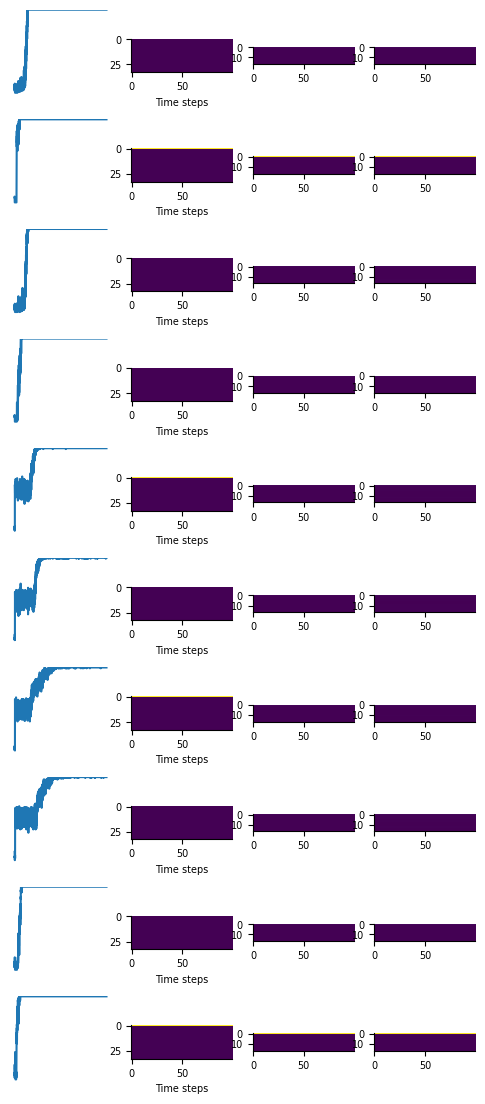

In [22]:
# fig, axes = plt.subplots(num_tasks,4, figsize=[6,14])
# for logi in range(num_tasks):
#     ax = axes[logi , 0 ]
#     ax.set_ylim([-0.1,1])
#     ax.axis('off')
#     log = training_logs[logi]
#     ax.plot(log['stamps'], log['accuracy'])
#     show_input_output(log['sample_input'], log['sample_label'], log['sample_output'], axes = axes[logi,1:])
# plt.show()

In [ ]:
#### draw input output
# plt.close('all')
# fig, axes = plt.subplots(20,3, figsize=[6,14])
# for i in range(20):
#     show_input_output(inputs[i].detach().cpu().numpy().T, labels[i].detach().cpu().numpy().T, outputs[i].detach().cpu().numpy().T, axes=axes[i,:])

# plt.show()